# Cartpole Bayesian Sindy

The full cartpole equations are:

$$\ddot{x}=\frac{f-ml\ddot{\theta}\cos{\theta} +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x}}{m_c + m}$$

$$\ddot{\theta}=\frac{Mg\sin{\theta} -\cos{\theta}(f +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x})-\frac{M\mu_p\dot{\theta}}{ml}}{(1+k)Ml-ml\cos^2{\theta}}$$

After filling in constants, the equations "simplify" to:

$$
\ddot{x} = a - b\ddot{\theta}\cos{\theta} + b\dot{\theta}^2\sin{\theta} - c\dot{x}
$$

$$
\ddot{\theta} = \frac{d\sin{\theta}-f\cos{\theta}-j\dot{\theta}^2\sin{\theta}\cos{\theta} + l\dot{x}\cos{\theta} - k\dot{\theta}}{h - j\cos^2{\theta}}
$$


In [ ]:
---
execute:
    echo: true
code-fold: true
output: html
toc: true
fig-align: center
fontsize: 16px
format:
    html:
        embed-resources: true
---

In [1]:
using Turing, DifferentialEquations, StatsPlots, LinearAlgebra, Random

## Sim Data

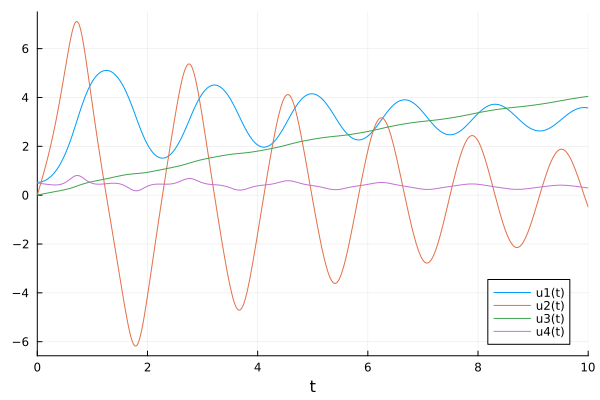

In [2]:
function cartpole!(du, u, p, t)
    # u = [theta, theta_d, x, x_d]

    # external force
    # force = -0.2+0.5*sin(6*t)
    force = 0

    # Parameters
    m1, m2, gravity, length, mu_c, mu_p, k_inertia = p

    # theta_d
    du[1] = u[2]

    # theta_dd
    du[2] = ((m1+m2)*gravity*sin(u[1])-cos(u[1])*(force+m2*length*(u[2]^2)*sin(u[1])-mu_c*u[4])-((m1+m2)*mu_p*u[2])/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(cos(u[1]))^2)

    # x_d
    du[3] = u[4]

    # x_dd
    du[4] = (force-m2*length*(du[2]*cos(u[1])-(u[2]^2)*sin(u[1]))-mu_c*u[4]) / (m1+m2)
end

# Parameters 
p = (1.0, 0.1, 9.8, 0.5, 0.05, 0.01, 1/3)

# Initial conditions
u0 = [0.524, 0.0, 0.0, 0.5]  # 30 degrees, 2 m/s to the right

tspan = (0.0,10.0)
probCart = ODEProblem(cartpole!,u0,tspan,p)

# Solve
sol = solve(probCart, Tsit5())

X = Array(sol)
t = sol.t
DX = Array(sol(sol.t,Val{1}))[[2], :]

plot(sol)

### Generate dummy data for estimation

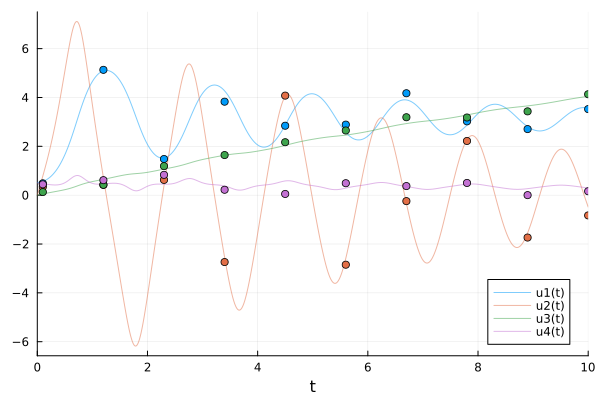

In [3]:
t = collect(range(0.1, stop=10, length=10))

odedata = Array(solve(probCart, saveat=t))
odedata = odedata + 0.2 * randn(size(odedata))
plot(sol; alpha=0.5)
scatter!(t, odedata'; color=[1 2 3 4], label="")


## Parameter Estimation

The cartpole system is more complicated than the pendulum for several reasons:

* 2 Equations to solve
* $\ddot{\theta}$ equation is super complex, can only roughly approximate

I'm especially interested to see how close $\ddot{\theta}$ can be approximated, and if the approximation holds up to a new starting configuration.

One of the hardest decisions is which set of basis functions to use?

* $\ddot{x}$ is a function of 4 variables: $\theta, \dot{\theta}, \ddot{\theta}, and \dot{x}$.
* $\ddot{\theta}$ is a function of 4 variables: $\theta, \dot{\theta}, and \dot{x}$.

I will start with 1st and 2nd powers and simple interactions of all terms, and use $sin(\theta)$ in place of $\theta$


In [4]:
#| output: false
function cartpoleSindy!(du, u, p, t)
    # u = [theta, theta_d, x, x_d]

    θ, θ̇, x, ẋ = u

    # theta_d and x_d
    du[1] = θ̇
    du[3] = ẋ

    # theta_dd
    θ̈ = (p[1]*sin(θ) +
         p[2]*θ̇ + 
         p[3]*ẋ +
         p[4]*θ̇ *sin(θ)+ 
         p[5]*ẋ *sin(θ)+ 
         p[6]*ẋ *θ̇ + 
         p[7]*sin(θ)^2+ 
         p[8]*θ̇ ^2+ 
         p[9]*ẋ^2)
    du[2] = θ̈ 

    # x_dd
    du[4] = (p[10]*sin(θ) +
             p[11]*θ̇ + 
             p[12]*θ̈  +
             p[13]*ẋ +
             p[14]*θ̇ *sin(θ)+ 
             p[15]*ẋ *sin(θ)+ 
             p[16]*ẋ *θ̇+ 
             p[17]*θ̈ *sin(θ)+ 
             p[18]*ẋ *θ̈ + 
             p[19]*θ̈  *θ̇+ 
             p[20]*sin(θ)^2+ 
             p[21]*θ̇ ^2+ 
             p[22]*θ̈  ^2+ 
             p[23]*ẋ^2)
end

cartpoleProb = ODEProblem(cartpoleSindy!, u0, tspan, [0.0 for _ in 1:23])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 4-element Vector{Float64}:
 0.524
 0.0
 0.0
 0.5

In [5]:
#| output: false
@model function fitCartpoleHorseshoe(data, ::Type{T} = Float64) where {T <: Real}
    # Prior distributions
    σ0 ~ InverseGamma(2, 3)
    J = 23
    ν_local = 3
    ν_global = 0.1
    τ₀=1
    slab_df=4
    slab_scale=2

    # Priors
    z ~ MvNormal(zeros(J), I) # Standard Normal for Coefs
    α ~ TDist(3) # Intercept
    σ ~ Exponential(1) # Errors
    λ ~ filldist(truncated(TDist(ν_local); lower=0), J)  # local shrinkage
    τ ~ (τ₀ * σ) * truncated(TDist(ν_global); lower=0)  # global shrinkage
    c_aux ~ InverseGamma(0.5 * slab_df, 0.5 * slab_df)
    
    # Transformations
    c = slab_scale * sqrt(c_aux)
    λtilde = λ ./ hypot.(1, (τ / c) .* λ)
    β = τ .* z .* λtilde # Regression coefficients

    p = convert.(T, β)
    u0 = convert.(T, cartpoleProb.u0)
    
    # Simulate model
    predicted = solve(cartpoleProb, Tsit5(); p=p, saveat=t)
    predicted_dense = solve(cartpoleProb, Tsit5(); p=p)
    failure = size(predicted, 2) < length(t)

    if failure
        Turing.@addlogprob! -Inf
        return
    end

    # # Observations
    # for i in 1:length(t)
    #     data[:, i] ~ MvNormal(predicted[:, i], σ0^2 * I)
    # end

    # return nothing
    return (; τ, σ, λ, λtilde, z, c, c_aux, α, β, predicted_dense)
end


fitCartpoleHorseshoe (generic function with 3 methods)

In [6]:
#| output: false
modelHorse = fitCartpoleHorseshoe(odedata)

# chain5 = sample(modelHorse, NUTS(0.65; init_ϵ=0.01), MCMCSerial(), 500, 2; progress=true)


DynamicPPL.Model{typeof(fitCartpoleHorseshoe), (:data, Symbol("##arg#378")), (Symbol("##arg#378"),), (), Tuple{Matrix{Float64}, DataType}, Tuple{DataType}, DynamicPPL.DefaultContext}(fitCartpoleHorseshoe, (data = [0.48475768104563893 5.132079383317527 … 2.705574591885531 3.5240973083742717; 0.33989010315453483 0.42606304815409196 … -1.7352374532977843 -0.8294703787809183; 0.12866761388125925 0.4231075193366911 … 3.4317244961971136 4.132086470240493; 0.4436784740648052 0.6142478866592587 … 0.0014526550034588692 0.16019611514741447], var"##arg#378" = Float64), (var"##arg#378" = Float64,), DynamicPPL.DefaultContext())

In [7]:
#| output: false
# Save/read samples
path = "../Data/chain-cartpole-hs-hard.jls"
if @isdefined chain5
    write(path, chain5)
else
    chain5 = read(path, Chains)
end

Chains MCMC chain (500×63×2 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 2
Samples per chain = 500
Wall duration     = 6260.46 seconds
Compute duration  = 6259.09 seconds
parameters        = σ0, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20], z[21], z[22], z[23], α, σ, λ[1], λ[2], λ[3], λ[4], λ[5], λ[6], λ[7], λ[8], λ[9], λ[10], λ[11], λ[12], λ[13], λ[14], λ[15], λ[16], λ[17], λ[18], λ[19], λ[20], λ[21], λ[22], λ[23], τ, c_aux
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          σ0    1.2483    0.1650     0.0052    0.0208   31.3530    1.0544

In [8]:
#| output: false
using DataFramesMeta

finnish_chain = generated_quantities(modelHorse, MCMCChains.get_sections(chain5, :parameters))
finnish_df = reduce(vcat, DataFrame(finnish_chain[:, i]) for i in 1:size(finnish_chain, 2))
@chain finnish_df begin
  @rselect @astable :β = :z * :τ .* :λtilde
  @combine :β_mean = mean(:β)
end

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.2521502746033766. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.2521502746033766. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\robert.robison\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:518


23×1 DataFrame
 Row │ β_mean     
     │ Float64    
─────┼────────────
   1 │  1.085
   2 │ -1.75403
   3 │  0.0570759
   4 │  1.30273
   5 │  0.81594
   6 │ -0.589671
   7 │  0.810709
   8 │ -1.25912
  ⋮  │     ⋮
  17 │ -0.392665
  18 │  0.620273
  19 │  0.403621
  20 │  0.443734
  21 │  0.35357
  22 │ -0.626088
  23 │ -0.812879
    8 rows omitted

In [13]:
#| output: false
using DataFrames

# Extract coefficient samples

# Clean data from generated quantites
samples = size(finnish_chain, 1)
var_str = [
    "\$sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{θ} \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} \\rightarrow \\ddot{θ}\$",
    "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{θ}\$",
    "\$sin(θ)^2 \\rightarrow \\ddot{θ}\$",
    "\$\\dot{θ}^2 \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x}^2 \\rightarrow \\ddot{θ}\$",
    "\$sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} \\rightarrow \\ddot{x}\$",
    "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ} * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$sin(θ)^2 \\rightarrow \\ddot{x}\$",
    "\$\\dot{θ}^2 \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ}^2 \\rightarrow \\ddot{x}\$",
    "\$\\dot{x}^2 \\rightarrow \\ddot{x}\$",
]
beta1 = DataFrame([finnish_chain[i, 1][:β] for i in 1:samples], :auto)
beta1[!,:var] = var_str
beta1[!,:chain] = [1 for _ in 1:size(beta1)[1]]
beta1 = DataFrames.stack(beta1, 1:samples)
beta2 = DataFrame([finnish_chain[i, 2][:β] for i in 1:samples], :auto)
beta2[!,:var] = var_str
beta2[!,:chain] = [2 for _ in 1:size(beta2)[1]]
beta2 = DataFrames.stack(beta2, 1:samples)
beta = vcat(beta1, beta2)
beta

23000×4 DataFrame
   Row │ var                                chain  variable  value      
       │ String                             Int64  String    Float64    
───────┼────────────────────────────────────────────────────────────────
     1 │ $sin(θ) \\rightarrow \\ddot{θ}$        1  x1         2.76657
     2 │ $\\dot{θ} \\rightarrow \\ddot{θ}$      1  x1         0.385834
     3 │ $\\dot{x} \\rightarrow \\ddot{θ}$      1  x1         0.583848
     4 │ $\\dot{θ} * sin(θ) \\rightarrow …      1  x1        -0.486335
     5 │ $\\dot{x} * sin(θ) \\rightarrow …      1  x1        -0.744371
     6 │ $\\dot{x} * \\dot{θ} \\rightarro…      1  x1        -1.10163
     7 │ $sin(θ)^2 \\rightarrow \\ddot{θ}$      1  x1        -0.786604
     8 │ $\\dot{θ}^2 \\rightarrow \\ddot{…      1  x1        -2.12633
   ⋮   │                 ⋮                    ⋮       ⋮          ⋮
 22994 │ $\\ddot{θ} * sin(θ) \\rightarrow…      2  x500       0.0749425
 22995 │ $\\dot{x} * \\dot{θ} \\rightarro…      2  x500      -0.260738
 22996 │ $\\ddot{θ} * \\dot{θ} \\rightarr…      2  x500       0.163394
 22997 │ $sin(θ)^2 \\rightarrow \\ddot{x}$      2  x500       0.222275
 22998 │ $\\dot{θ}^2 \\rightarrow \\ddot{…      2  x500      -0.245664
 22999 │ $\\ddot{θ}^2 \\rightarrow \\ddot…      2  x500       1.30397
 23000 │ $\\dot{x}^2 \\rightarrow \\ddot{…      2  x500      -0.98973
                                                      22985 rows omitted

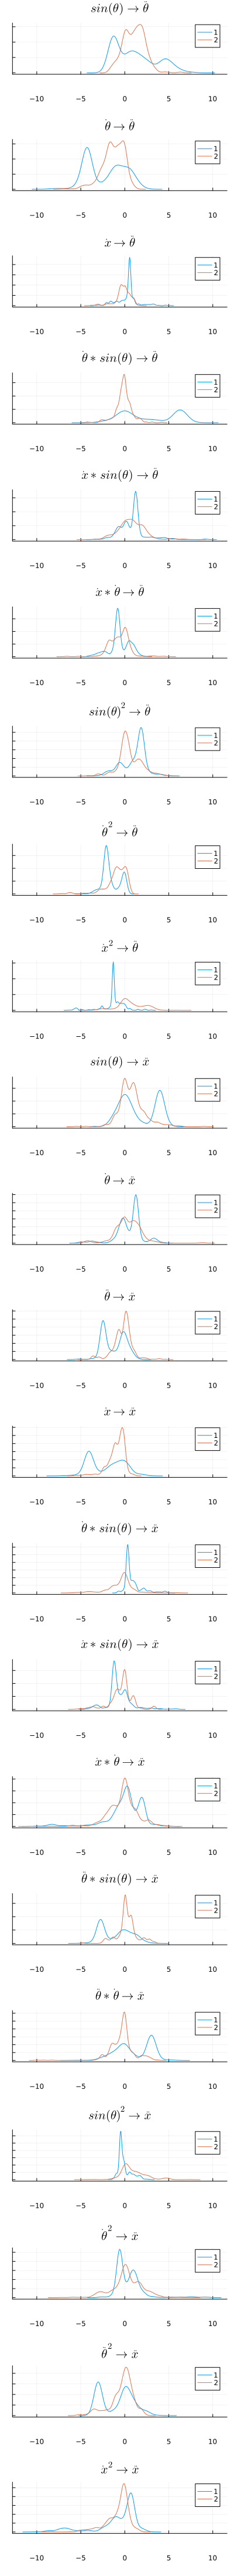

In [23]:
#| output: false
#| echo: false
gdf = groupby(beta, :var)
plot_list = []
for ((k,), v) in pairs(gdf)
    push!(plot_list, @df v density(:value, group=(:chain), title=k))
end

plot(plot_list..., layout=(length(plot_list), 1), size=(400, 200 * length(plot_list)), link = :x)
    


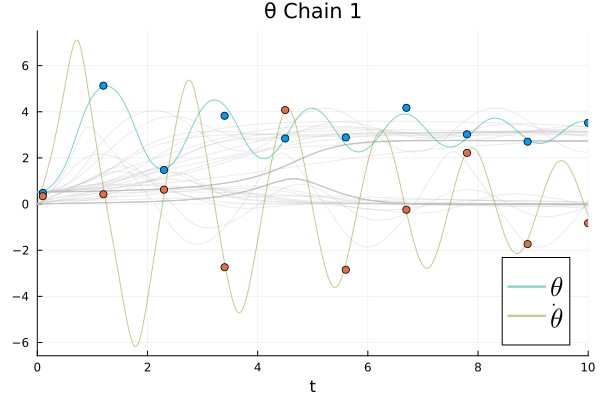

In [36]:
#| output: false
#| echo: false
plot(; title="θ Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 1:25:500
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=1, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


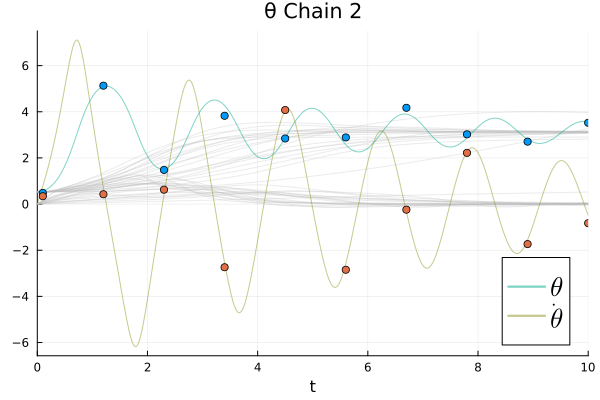

In [37]:
#| output: false
#| echo: false
plot(; title="θ Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 501:25:1000
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=1, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


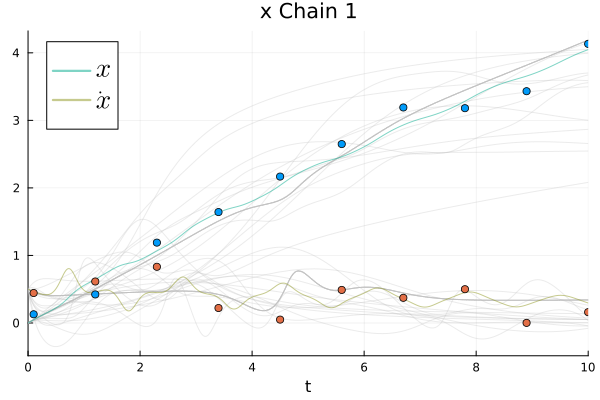

In [38]:
#| output: false
#| echo: false
plot(; title="x Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 1:size(finnish_df, 1)
for i in 1:25:500
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=1, label=["\$x\$" "\$\\dot{x}\$"])
scatter!(t, odedata[3:4, :]'; color=[1 2], label="")


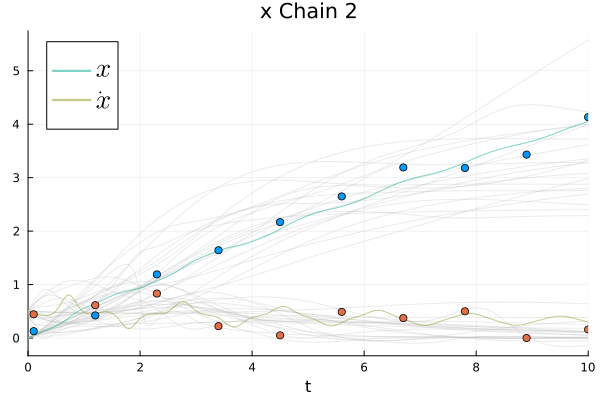

In [39]:
#| output: false
#| echo: false

plot(; title="x Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 1:size(finnish_df, 1)
for i in 501:25:1000
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=1, label=["\$x\$" "\$\\dot{x}\$"])
scatter!(t, odedata[3:4, :]'; color=[1 2], label="")


## Summary

The chains found slightly different solutions; both were pretty bad. They pick up on the general trends in x, but aren't able to do so with $\theta$